In [2]:
# !pip install tensorflow

In [36]:
# !pip install imblearn

     -------------------------------------- 235.6/235.6 kB 2.1 MB/s eta 0:00:00


In [227]:
#3.11.4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [105]:
data = pd.read_csv('./cancerDataset/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [106]:
labels = data['label']
data = data.drop(['label'], axis=1)

In [107]:
# data.head()

In [108]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)

x_train shape:  (8012, 2352)
y_train shape:  (8012,)


In [109]:
import random
from imblearn.over_sampling import RandomOverSampler 

x_train=np.array(x_train).reshape(-1,28,28,3)

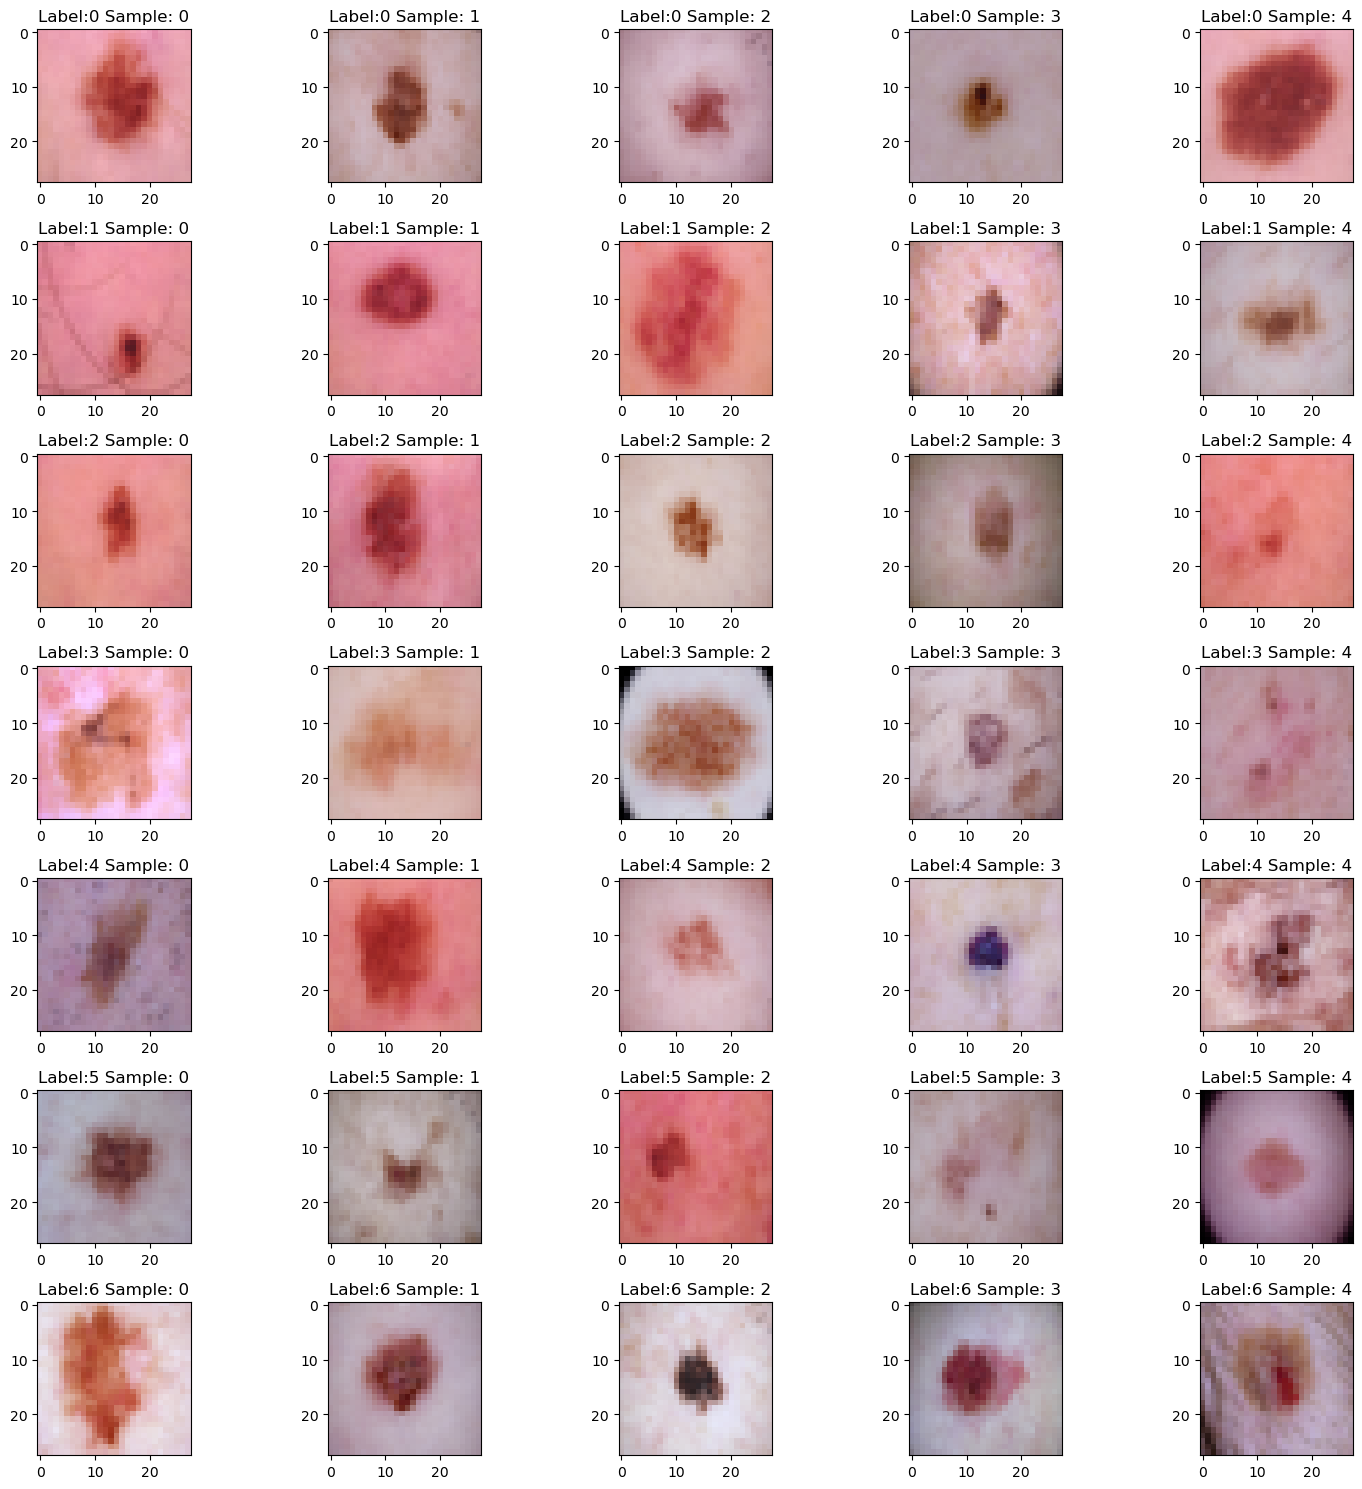

In [292]:
#show training 5 samples for each class
fig, ax = plt.subplots(7,5)
fig.set_size_inches(15,15)
for i in range(7):
    for j in range (5):
        randomIndex = random.randint(0, len(x_train))
        ax[i,j].imshow(x_train[randomIndex])
        ax[i,j].set_title("Label:" + str(i) + " Sample: " + str(j))
        # ax[i,j].set_title(y_train[randomIndex])
plt.tight_layout()


In [212]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout

# CNN
model = keras.Sequential()
model.add(Conv2D(32, kernel_size = (2,2), input_shape = (28, 28, 3), activation = 'relu'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size = (5,5), activation = 'relu')) # bigger kernel
model.add(Conv2D(32, kernel_size = (1,1), activation = 'relu')) # reduce depth
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization()) # normalize

model.add(Flatten())

# NN
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7,activation='softmax'))

model.summary()


Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_438 (Conv2D)         (None, 27, 27, 32)        416       
                                                                 
 conv2d_439 (Conv2D)         (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_152 (MaxPooli  (None, 12, 12, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_440 (Conv2D)         (None, 8, 8, 64)          102464    
                                                                 
 conv2d_441 (Conv2D)         (None, 8, 8, 32)          2080      
                                                                 
 max_pooling2d_153 (MaxPooli  (None, 4, 4, 32)         0         
 ng2D)                                               

In [213]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) #0.001
model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

status = model.fit(x_train, y_train,validation_split=0.3, epochs=50, batch_size=128,shuffle=True,user_multiprocessing=True)

Epoch 1/50
44/44 [==============================] - 11s 197ms/step - loss: 1.4134 - accuracy: 0.5078 - val_loss: 5.8145 - val_accuracy: 0.6755
Epoch 2/50
44/44 [==============================] - 8s 189ms/step - loss: 0.9859 - accuracy: 0.6555 - val_loss: 3.1060 - val_accuracy: 0.5470
Epoch 3/50
44/44 [==============================] - 8s 190ms/step - loss: 0.8940 - accuracy: 0.6762 - val_loss: 1.1990 - val_accuracy: 0.6273
Epoch 4/50
44/44 [==============================] - 8s 192ms/step - loss: 0.8487 - accuracy: 0.6965 - val_loss: 1.3936 - val_accuracy: 0.5836
Epoch 5/50
44/44 [==============================] - 9s 206ms/step - loss: 0.7938 - accuracy: 0.7156 - val_loss: 1.0523 - val_accuracy: 0.6626
Epoch 6/50
44/44 [==============================] - 9s 208ms/step - loss: 0.7634 - accuracy: 0.7143 - val_loss: 1.5040 - val_accuracy: 0.6606
Epoch 7/50
44/44 [==============================] - 9s 206ms/step - loss: 0.7390 - accuracy: 0.7322 - val_loss: 1.8424 - val_accuracy: 0.6785
Epoch

In [214]:
model.save('task1.h5')


In [215]:
x_test=np.array(x_test).reshape(-1,28,28,3)

In [216]:
x_test.shape

(2003, 28, 28, 3)

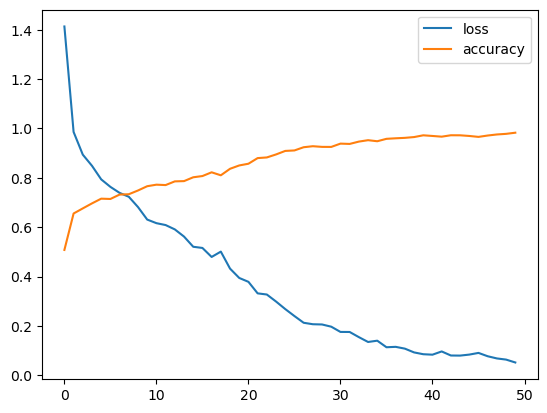

In [219]:
plt.plot(status.history['loss'])
plt.plot(status.history['accuracy'])
plt.legend(['loss','accuracy'])


In [277]:
status = model.evaluate(x_test, y_test,use_multiprocessing=True)

63/63 [==============================] - 1s 14ms/step - loss: 1.5805 - accuracy: 0.7314


In [270]:
# predict classes
def predict_classes(model, x_test):
    y_pred = model.predict(x_test)
    classes = np.argmax(y_pred, axis = 1)
    return classes

In [293]:
# plot test error
print("Test Loss:", status[0]) 
print("Test Accuracy:", status[1])


Test Loss: 1.580474853515625
Test Accuracy: 0.7314028739929199


In [302]:
def calculateAccuracy(comfusionMatrix):
    accuracy = 0
    for i in range(len(comfusionMatrix)):
        accuracy += comfusionMatrix[i][i]
    return accuracy/np.sum(comfusionMatrix)

def calculatePrecicion(comfusionMatrix):
    precision = 0
    for i in range(len(comfusionMatrix)):
        precision += comfusionMatrix[i][i]/np.sum(comfusionMatrix[:,i])
    return precision/len(comfusionMatrix)

def calculateRecall(comfusionMatrix):
    recall = 0
    for i in range(len(comfusionMatrix)):
        recall += comfusionMatrix[i][i]/np.sum(comfusionMatrix[i,:])
    return recall/len(comfusionMatrix)

# revise these functions

63/63 [==============================] - 1s 13ms/step
Accuracy:  0.7314028956565152
Precision:  0.4993367299753336
Recall:  0.4384955107931328
              precision    recall  f1-score   support

           0       0.34      0.20      0.25        69
           1       0.48      0.55      0.51        93
           2       0.57      0.36      0.45       228
           3       0.31      0.14      0.20        28
           4       0.81      0.93      0.86      1338
           5       0.57      0.62      0.59        21
           6       0.42      0.27      0.33       226

    accuracy                           0.73      2003
   macro avg       0.50      0.44      0.46      2003
weighted avg       0.70      0.73      0.71      2003



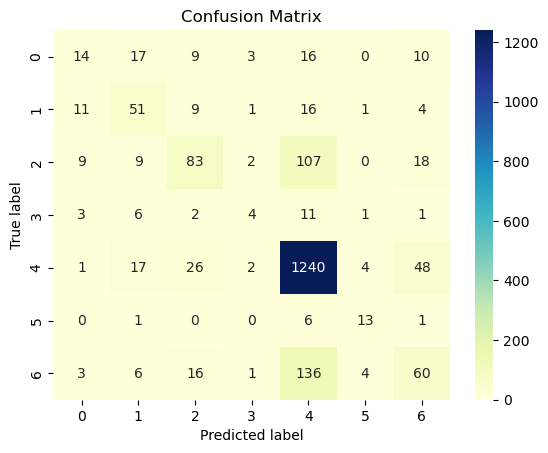

In [310]:
# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = predict_classes(model, x_test)
confusionMatrixData = confusion_matrix(y_test, y_pred)
# heat map of confusion matrix with x and y axis labels
fig = sns.heatmap(confusionMatrixData, annot=True, fmt="d", cmap="YlGnBu", xticklabels=range(7), yticklabels=range(7))
fig.set(xlabel='Predicted label', ylabel='True label', title='Confusion Matrix')

print("Accuracy: ", calculateAccuracy(confusionMatrixData))
print("Precision: ", calculatePrecicion(confusionMatrixData))
print("Recall: ", calculateRecall(confusionMatrixData))

print(metrics.classification_report(y_test, y_pred))